# Introduction
This is essentially an application of this Medium article : https://ericchen556.medium.com/quant-investment-how-i-construct-factors-for-alpha-research-feature-engineering-bd64309c9218

The goal is to construct lagged return and momentum factors, Fama Factors, and other discretionary factors like sector and industry

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
PeriodStart = "2019-01-01"
PeriodEnd = "2024-07-05"

tickerlist = ["NVDA", "MSFT", "AAPL"]
df = yf.download(tickerlist, start=PeriodStart, end=PeriodEnd)
df.head()

[*********************100%%**********************]  3 of 3 completed


Price       Adj Close                           Close                       \
Ticker           AAPL       MSFT      NVDA       AAPL        MSFT     NVDA   
Date                                                                         
2019-01-02  37.793777  95.673454  3.378612  39.480000  101.120003  3.40550   
2019-01-03  34.029240  92.153824  3.174486  35.547501   97.400002  3.19975   
2019-01-04  35.481922  96.439804  3.377867  37.064999  101.930000  3.40475   
2019-01-07  35.402950  96.562813  3.556694  36.982498  102.059998  3.58500   
2019-01-08  36.077839  97.262970  3.468149  37.687500  102.800003  3.49575   

Price            High                             Low                       \
Ticker           AAPL        MSFT     NVDA       AAPL        MSFT     NVDA   
Date                                                                         
2019-01-02  39.712502  101.750000  3.46200  38.557499   98.940002  3.25125   
2019-01-03  36.430000  100.190002  3.37900  35.500000   97.199997  3.19225   
2019-01-04  37.137501  102.510002  3.44325  35.950001   98.930000  3.24250   
2019-01-07  37.207500  103.269997  3.62225  36.474998  100.980003  3.41075   
2019-01-08  37.955002  103.970001  3.66950  37.130001  101.709999  3.42250   

Price            Open                          Volume                       
Ticker           AAPL        MSFT     NVDA       AAPL      MSFT       NVDA  
Date                                                                        
2019-01-02  38.722500   99.550003  3.26600  148158800  35329300  508752000  
2019-01-03  35.994999  100.099998  3.34475  365248800  42579100  705552000  
2019-01-04  36.132500   99.720001  3.27350  234428400  44060600  585620000  
2019-01-07  37.174999  101.639999  3.46250  219111200  35656100  709160000  
2019-01-08  37.389999  103.040001  3.66725  164101200  31514400  786016000

Since we are only concerned with the Adj Close price section of the dataframe, we can repurpose the dataframe to only reflect that

In [3]:
df = df["Adj Close"]
df.head()

Ticker,AAPL,MSFT,NVDA
Date,,,
2019-01-02,37.793777,95.673454,3.378612
2019-01-03,34.029240,92.153824,3.174486
2019-01-04,35.481922,96.439804,3.377867
2019-01-07,35.402950,96.562813,3.556694
2019-01-08,36.077839,97.262970,3.468149


Here the author has used monthly rebalancing strategies for the momentum instead of identifying daily momentum trends ; so we follow him for that

In [4]:
df_monthly = df.resample('M').last()
print(len(df), len(df_monthly))
df_monthly.tail()

1385 67


Ticker,AAPL,MSFT,NVDA
Date,,,
2024-03-31,171.247726,419.962494,90.348579
2024-04-30,170.099289,388.628998,86.394905
2024-05-31,192.250000,415.130005,109.624001
2024-06-30,210.619995,446.950012,123.540001
2024-07-31,221.550003,460.769989,128.279999


This tells us that we go through 1385 days but 67 months ; and we get the data for the last 5 months


#Data Transformation and Processing

We now move on to calculate the returns over a 1-month, 2-month, 3-month , etc. period for each ticker

We then carry out the *Winsorization* of of our data to eliminate outliers

Branching off the main trunk to understand what winsorization is : it is the replacement of outlier data by the nearest non-outlier data

This is different from clipping in the fact that clipping simply removes the outlier data ; here we replace it by the nearest non-outlier data

We consider the outliers to be the top and bottom 5%

In case of returns of more than one month, we compound them back to monthly rates

In [5]:
lags = [1,2,3,6,9,12,24]
df_momentum = pd.DataFrame()
outlier_cutoff = 0.05

for lag in lags :
  df_momentum[f'return_{lag}m'] = (df_monthly.pct_change(lag).stack().pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1))


df_momentum = df_momentum.swaplevel().sort_index()
df_momentum

return_1m  return_2m  return_3m  return_6m  return_9m  \
Ticker Date                                                                
AAPL   2019-02-28   0.044777        NaN        NaN        NaN        NaN   
       2019-03-31   0.097026   0.070582        NaN        NaN        NaN   
       2019-04-30   0.056436   0.076539   0.065846        NaN        NaN   
       2019-05-31  -0.118938  -0.038120   0.004969        NaN        NaN   
       2019-06-30   0.130519  -0.004965   0.015095        NaN        NaN   
...                      ...        ...        ...        ...        ...   
NVDA   2024-03-31   0.142181   0.171231   0.142453   0.129408   0.088008   
       2024-04-30  -0.043760   0.045083   0.119849   0.129408   0.070706   
       2024-05-31   0.218827   0.101519   0.114910   0.129408   0.092755   
       2024-06-30   0.126943   0.171231   0.109930   0.129408   0.098630   
       2024-07-31   0.038368   0.081749   0.140837   0.129408   0.098630   

                   return_12m  return_24m  
Ticker Date                                
AAPL   2019-02-28         NaN         NaN  
       2019-03-31         NaN         NaN  
       2019-04-30         NaN         NaN  
       2019-05-31         NaN         NaN  
       2019-06-30         NaN         NaN  
...                       ...         ...  
NVDA   2024-03-31    0.098765    0.051211  
       2024-04-30    0.098765    0.066268  
       2024-05-31    0.092739    0.069036  
       2024-06-30    0.093448    0.069036  
       2024-07-31    0.087824    0.069036  

[198 rows x 7 columns]

# The Mathematics Behind The Code

Now, there is a lot of bewilderment as to what happened here

The code calculates the lagged monthly returns while handling outliers. It first computes the percentage change over a specified lag period and then stacks the data for easier manipulation

The stacking of the data, to be honest, is an operational nececessity and has nothing to do with mathematical logic

Outliers are clipped to within the specified quantiles. Each value is then adjusted by adding 1, raising to the power of the inverse of the lag period to get the *geometric mean*, and finally subtracting 1 to convert back to percentage change format This processed series is stored in the `df_momentum` DataFrame as `return_{lag}m`

In conclusion, all of these numbers are monthly de-compounded returns over different lengths of time

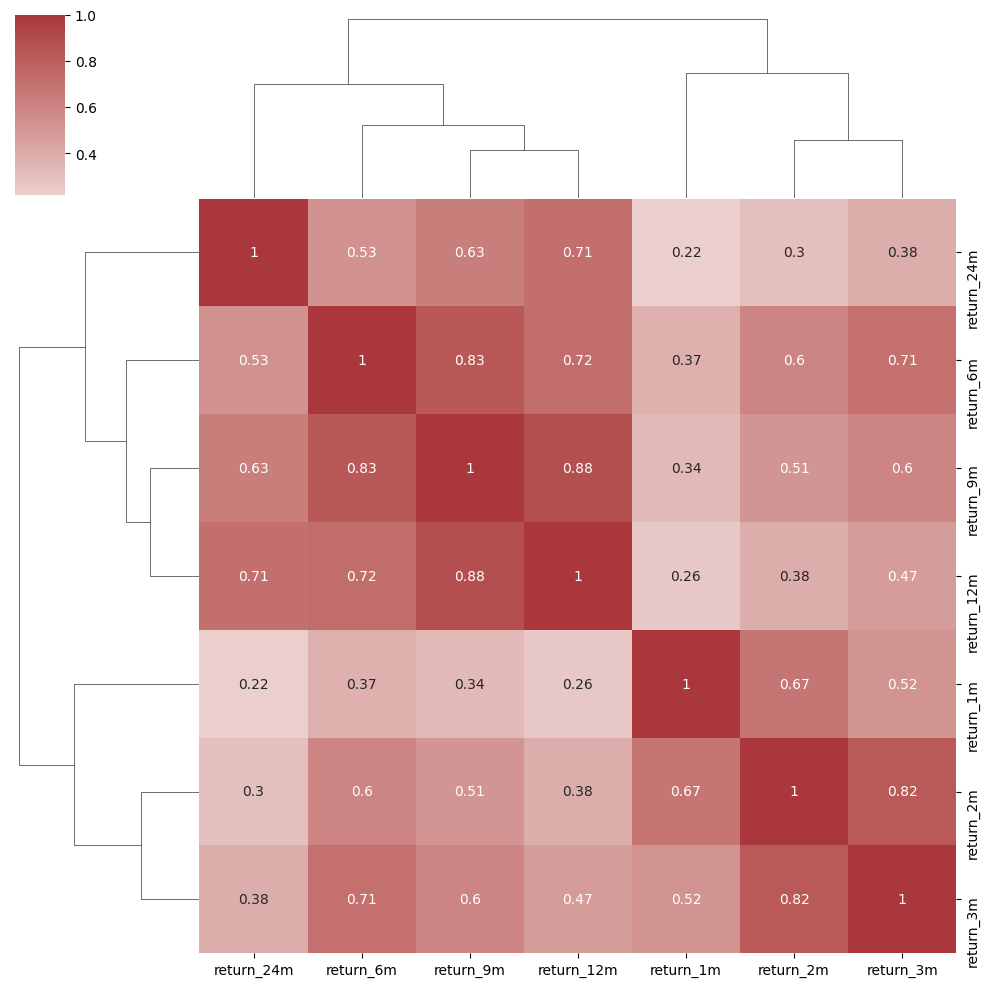

In [6]:
import seaborn as sns
sns.clustermap(df_momentum.corr('spearman'), annot = True, center = 0 , cmap = 'vlag')

# Understanding Correlation between Varying Time Periods

The cluster map helps us visualize the correlation between returns for different periods

It is obvious that the correlation for the same time periods will be 1 ; they are one and the same !

Let us understand with a simple example; in the fifth row, and the first column, lies the value 0.082 : this tells us that the correlation between the returns in one month and returns in 24 months is only 0.082 : which is very poor

Logically, this gives us an intuitive feel that the momentum of one month does not carry to 24 months !

On a side note, of course this matrix is symmetric


# Constructing Momentum

To get momentum , we calculate the first degree difference of monthly returns against the most recent month

In [7]:
for lag in [2,3,6,9,12,24] :
    df_momentum[f'return_{lag}m_1m'] = df_momentum[f'return_{lag}m'] - df_momentum['return_1m']

df_momentum

return_1m  return_2m  return_3m  return_6m  return_9m  \
Ticker Date                                                                
AAPL   2019-02-28   0.044777        NaN        NaN        NaN        NaN   
       2019-03-31   0.097026   0.070582        NaN        NaN        NaN   
       2019-04-30   0.056436   0.076539   0.065846        NaN        NaN   
       2019-05-31  -0.118938  -0.038120   0.004969        NaN        NaN   
       2019-06-30   0.130519  -0.004965   0.015095        NaN        NaN   
...                      ...        ...        ...        ...        ...   
NVDA   2024-03-31   0.142181   0.171231   0.142453   0.129408   0.088008   
       2024-04-30  -0.043760   0.045083   0.119849   0.129408   0.070706   
       2024-05-31   0.218827   0.101519   0.114910   0.129408   0.092755   
       2024-06-30   0.126943   0.171231   0.109930   0.129408   0.098630   
       2024-07-31   0.038368   0.081749   0.140837   0.129408   0.098630   

                   return_12m  return_24m  return_2m_1m  return_3m_1m  \
Ticker Date                                                             
AAPL   2019-02-28         NaN         NaN           NaN           NaN   
       2019-03-31         NaN         NaN     -0.026443           NaN   
       2019-04-30         NaN         NaN      0.020104      0.009410   
       2019-05-31         NaN         NaN      0.080818      0.123907   
       2019-06-30         NaN         NaN     -0.135484     -0.115424   
...                       ...         ...           ...           ...   
NVDA   2024-03-31    0.098765    0.051211      0.029049      0.000272   
       2024-04-30    0.098765    0.066268      0.088844      0.163609   
       2024-05-31    0.092739    0.069036     -0.117308     -0.103917   
       2024-06-30    0.093448    0.069036      0.044288     -0.017013   
       2024-07-31    0.087824    0.069036      0.043381      0.102469   

                   return_6m_1m  return_9m_1m  return_12m_1m  return_24m_1m  
Ticker Date                                                                  
AAPL   2019-02-28           NaN           NaN            NaN            NaN  
       2019-03-31           NaN           NaN            NaN            NaN  
       2019-04-30           NaN           NaN            NaN            NaN  
       2019-05-31           NaN           NaN            NaN            NaN  
       2019-06-30           NaN           NaN            NaN            NaN  
...                         ...           ...            ...            ...  
NVDA   2024-03-31     -0.012774     -0.054173      -0.043416      -0.090970  
       2024-04-30      0.173168      0.114466       0.142525       0.110028  
       2024-05-31     -0.089420     -0.126072      -0.126088      -0.149791  
       2024-06-30      0.002465     -0.028313      -0.033495      -0.057907  
       2024-07-31      0.091039      0.060261       0.049456       0.030668  

[198 rows x 13 columns]

# Fama Factors
Now we go on to build Fama factors

First up we need to understand what RollingOLS is :  

Rolling OLS involves analyzing a time series by estimating a linear regression model within a *moving window of fixed size* rather than taking the complete dataset *all at once*

For each window, you perform an OLS regression to determine the relationship between the independent and dependent variables

As the window moves forward one time step at a time, you get a new set of regression coefficients

This process creates a time series of coefficients, which shows how the relationship between the variables evolves over time

So if you have a window of size = 10 ; you would first perform OLS regression on the first 10 values, then on values numbered from 2 to 11, then from 3 to 12 and so on

We then go on to fetch the Fama French 5 factors data from the Web

We drop the risk free rate data since we our only comparing excess returns exemplified by these financial instruments

The Fama French factors help is asset pricing by considering a number of factors such as market excess return, size, value, profitability etc

Then we convert the dataframe into a proper timestamp format

I really do not see why we do this

We then go on to resample the data to only look into monthly frequencies

Oh, now I see why we did the timestamping

Since we have performed our analysis above in monthly terms, we first uniformly timestamped the data into daily returns then went on to uniformly distribute it in monthly terms

We then carry out a simple operation to join the Fama French factors dataframe to the momentum dataframe

This allows us to carry out a regressio and statistical analysis and analyse how the explanatory variables (the F-F factors) affect the dependent variables (the monthly-returns of the under-study financial instruments)





In [8]:
import warnings
warnings.filterwarnings('ignore')

import pandas_datareader.data as web
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

#get the fama factors
fama_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
fama_factors.index = fama_factors.index.to_timestamp()
fama_factors = fama_factors.resample('M').last()

#join factors with the actual monthly return
fama_factors = fama_factors.join(df_momentum['return_1m'])

In [9]:
fama_factors

Mkt-RF   SMB   HML   RMW   CMA  return_1m
Ticker Date                                                 
AAPL   2019-02-28    3.40  1.74 -2.67  0.12 -1.59   0.044777
       2019-03-31    1.10 -3.51 -4.17  0.90 -0.95   0.097026
       2019-04-30    3.97 -1.17  2.15  1.61 -2.22   0.056436
       2019-05-31   -6.94 -1.59 -2.37 -0.46  1.77  -0.118938
       2019-06-30    6.93  0.37 -0.71  0.90 -0.44   0.130519
...                   ...   ...   ...   ...   ...        ...
NVDA   2024-01-31    0.70 -5.74 -2.38  0.69 -0.95   0.218827
       2024-02-29    5.06 -0.78 -3.49 -1.99 -2.14   0.218827
       2024-03-31    2.83 -1.16  4.20  1.49  1.17   0.142181
       2024-04-30   -4.67 -2.55 -0.52  1.49 -0.30  -0.043760
       2024-05-31    4.34  0.59 -1.33  3.21 -2.87   0.218827

[192 rows x 6 columns]

# F-F Factors Correlation Analysis

We first set the general rolling window as T = 12

We then go on to find the betas for different time frames for different financial instruments

This is a tedious bit of code but is actually quite simple

We first seek to group the betas as per the financial instrument they belong to ; then we apply a lambda function on them

And what is that lambda function ? To find the betas, we carry out a regression where between the monthly returns (here for a single month) and the F-F factors

We drop the constant term that appears in the linear equation to get only the slope of the line : the beta

We then make a cluster map comparing the correlation between the impact different factors have on the monthly returns

As is apparent , the diagonal is 1 , since the same factor will have equivalent impact on the monthly returns :)

Needless to say, this is a symmetric matrix

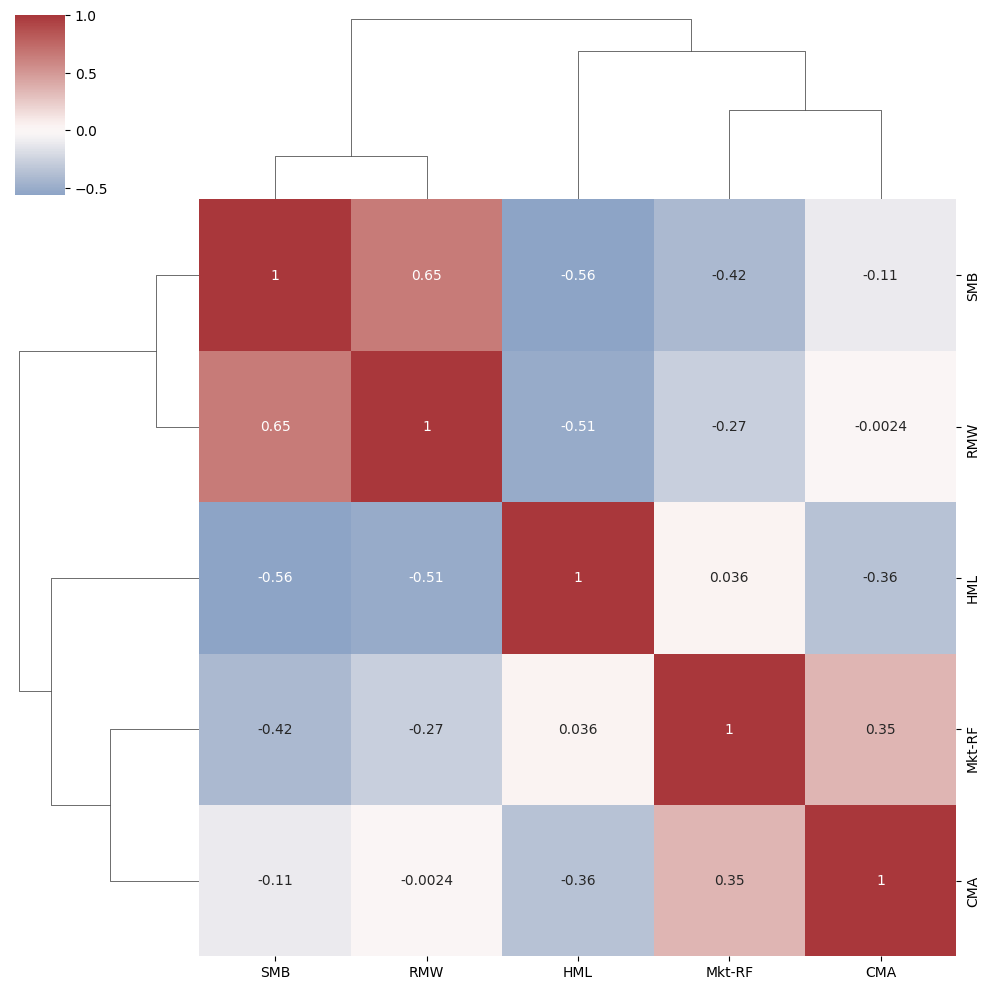

In [10]:
T = 12
betas = (fama_factors.groupby(level = 'Ticker', group_keys = False).apply(lambda x : RollingOLS(endog = x.return_1m, exog = sm.add_constant(x.drop('return_1m', axis = 1)), window = min(T,x.shape[0] -1)).fit(params_only = True).params.drop('const', axis = 1)))

betas.describe()

sns.clustermap(betas.dropna().corr(), annot = True, center = 0, cmap = 'vlag')

# Understanding The Factors

**Mkt-RF**

Mkt-RF stands for the market excess return, which is the return of the market portfolio minus the risk-free rate

Mkt-RF = R<sub>m</sub> - R<sub>f</sub>
where R<sub>m</sub> is the return of the market portfolio and R<sub>f</sub> is the risk-free rate

This factor represents the additional return that investors expect to earn from investing in the overall market (e.g., S&P 500) instead of a risk-free asset (e.g., Treasury bills)

In essence this is the the compensation investors demand for taking on the higher risk associated with the stock market compared to risk-free investments

**SMB**

SMB stands for Small Minus Big and represents the size factor, calculated as the return difference between small-cap (small market capitalization) stocks and large-cap (large market capitalization) stocks

SMB = R<sub>small</sub> - R<sub>big</sub>
where R<sub>small</sub> is the average return of small-cap stocks and R<sub>big</sub> is the average return of large-cap stocks

In essence this factor captures the size premium, that is the historical tendency for small-cap stocks to outperform large-cap stocks

The intuition is that small-cap stocks are generally riskier and less liquid than large-cap stocks, so investors demand higher returns for holding them

**HML**

HML stands for High Minus Low and represents the value factor, calculated as the return difference between high book-to-market (value stocks, since the market value is low and they have not yet realised their potential, thus being cheaper in value and providing better returns) stocks and low book-to-market (growth stocks, since their perceived value in the market is greater than their book value , meaning that investors are scrambling for these stocks) stocks

HML = R<sub>high</sub> - R<sub>low</sub>

where R<sub>high</sub>  is the average return of high book-to-market ratio stocks and R<sub>low</sub> is the average return of low book-to-market ratio stocks

The intuition here is that value stocks are often perceived as being undervalued and therefore offer higher returns as compensation for their perceived higher risk

**RMW**

RMW stands for Robust Minus Weak and represents the profitability factor, calculated as the return difference between stocks of companies with robust (high) profitability and those with weak (low) profitability
RMW = R<sub>robust</sub> - R<sub>weak</sub>

where R<sub>robust</sub> is the average return of companies with high profitability and R<sub>weak</sub> is the average return of companies with low profitability

The intuition is that more profitable companies are generally better managed and more resilient, leading to higher expected returns

**CMA**

CMA stands for Conservative Minus Aggressive and represents the investment factor, calculated as the return difference between companies that invest conservatively (low asset growth) and those that invest aggressively (high asset growth)

CMA = R<sub>conservative</sub> - R<sub>aggressive</sub>

where R<sub>conservative</sub> is the average return of companies with low asset growth and R<sub>aggressive</sub> is the average return of companies with high asset growth


The intuition is that companies investing aggressively might be taking on too much risk or misallocating resources, which can lead to lower future returns



# Conclusion

We see that there is a negative correlation between CMA and Mkt-RF ; and a strong positive correlation between SMB and RMW ; we can accordingly update our strategy


In [11]:
betas.describe()

,Mkt-RF,SMB,HML,RMW,CMA
count,159.000000,159.000000,159.000000,159.000000,159.000000
mean,0.010425,-0.002011,-0.006143,0.003897,0.000449
std,0.005458,0.011260,0.007100,0.012637,0.010723
min,-0.005097,-0.051948,-0.027473,-0.057618,-0.024694
25%,0.007304,-0.008672,-0.009645,-0.002581,-0.005584
50%,0.010101,-0.003859,-0.005309,0.003856,-0.000331
75%,0.013877,0.003317,-0.002031,0.009153,0.006943
max,0.032438,0.042010,0.018817,0.038307,0.041372


In [12]:
df_momentum = df_momentum.join(betas.groupby(level = 'Ticker').shift()).dropna()
df_momentum.info()
df_momentum[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].describe()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 123 entries, ('AAPL', Timestamp('2021-01-31 00:00:00')) to ('NVDA', Timestamp('2024-05-31 00:00:00'))
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1m      123 non-null    float64
 1   return_2m      123 non-null    float64
 2   return_3m      123 non-null    float64
 3   return_6m      123 non-null    float64
 4   return_9m      123 non-null    float64
 5   return_12m     123 non-null    float64
 6   return_24m     123 non-null    float64
 7   return_2m_1m   123 non-null    float64
 8   return_3m_1m   123 non-null    float64
 9   return_6m_1m   123 non-null    float64
 10  return_9m_1m   123 non-null    float64
 11  return_12m_1m  123 non-null    float64
 12  return_24m_1m  123 non-null    float64
 13  Mkt-RF         123 non-null    float64
 14  SMB            123 non-null    float64
 15  HML            123 non-null    float64
 16  RMW            123

,Mkt-RF,SMB,HML,RMW,CMA
count,123.000000,123.000000,123.000000,123.000000,123.000000
mean,0.010568,-0.003369,-0.006582,0.003349,-0.000186
std,0.004365,0.010148,0.006747,0.012132,0.008417
min,0.001047,-0.051948,-0.026776,-0.057618,-0.021552
25%,0.007383,-0.009093,-0.010154,-0.002581,-0.004974
50%,0.010336,-0.004504,-0.005793,0.004148,-0.000503
75%,0.013877,0.001427,-0.002554,0.008490,0.005676
max,0.020499,0.029114,0.018817,0.034785,0.021471


In [13]:
!pip install yahooquery
import yahooquery as yq
import pandas as pd

tickers = yq.Ticker(tickerlist)
df_ref = pd.DataFrame(tickers.asset_profile)
df_sector = df_ref.loc['sector', :].to_frame()

df_sector.index = df_sector.index.rename('Ticker') # Rename the index to 'Ticker'
df_sector # Now df_sector should be defined and display correctly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 759.5 kB/s eta 0:00:00


,sector
Ticker,
NVDA,Technology
MSFT,Technology
AAPL,Technology


In [14]:
df_momentum = df_momentum.join(df_sector)

df_dummy = pd.get_dummies(df_momentum, columns = ['sector'])

df_dummy = df_dummy.rename(columns = lambda x: x.replace('sector_', ' '))
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 123 entries, ('AAPL', Timestamp('2021-01-31 00:00:00')) to ('NVDA', Timestamp('2024-05-31 00:00:00'))
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1m      123 non-null    float64
 1   return_2m      123 non-null    float64
 2   return_3m      123 non-null    float64
 3   return_6m      123 non-null    float64
 4   return_9m      123 non-null    float64
 5   return_12m     123 non-null    float64
 6   return_24m     123 non-null    float64
 7   return_2m_1m   123 non-null    float64
 8   return_3m_1m   123 non-null    float64
 9   return_6m_1m   123 non-null    float64
 10  return_9m_1m   123 non-null    float64
 11  return_12m_1m  123 non-null    float64
 12  return_24m_1m  123 non-null    float64
 13  Mkt-RF         123 non-null    float64
 14  SMB            123 non-null    float64
 15  HML            123 non-null    float64
 16  RMW            123

# Final Comments

Now we have effectively constructed features before applying any kinds of machine learning algorithm on forecasing

:)

Now I have to figure out a way applying time series forecasting on this dataframe